In [35]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np

In [36]:
from services.SQLiteService import SQLiteService

database = SQLiteService()
database.connect()
data = database.select_data()

In [37]:
import pandas as pd
from datetime import datetime

# Conversion en DataFrame
df = pd.DataFrame(data)

# Conversion de la colonne datetime en type datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M')

# Définition de l'index temporel
df = df.set_index('datetime').sort_index()

# Vérification des types
print(df.dtypes)

temperature    float64
dtype: object


In [38]:
df.head()

,temperature
datetime,
2025-01-01 00:00:00,0.8
2025-01-01 01:00:00,2.1
2025-01-01 02:00:00,2.6
2025-01-01 03:00:00,3.1
2025-01-01 04:00:00,3.6


In [39]:
from statsmodels.tsa.stattools import adfuller

# Effectuer le test ADF
result = adfuller(df['temperature'])

# Afficher les résultats
print("Statistique de test ADF:", result[0])
print("p-value:", result[1])
print("Nombre de retards utilisés:", result[2])
print("Nombre d'observations:", result[3])
print("Valeurs critiques:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

Statistique de test ADF: -2.506272107825606
p-value: 0.1139557021576712
Nombre de retards utilisés: 21
Nombre d'observations: 770
Valeurs critiques:
   1%: -3.4388710830827125
   5%: -2.8653008652386576
   10%: -2.568772659807725


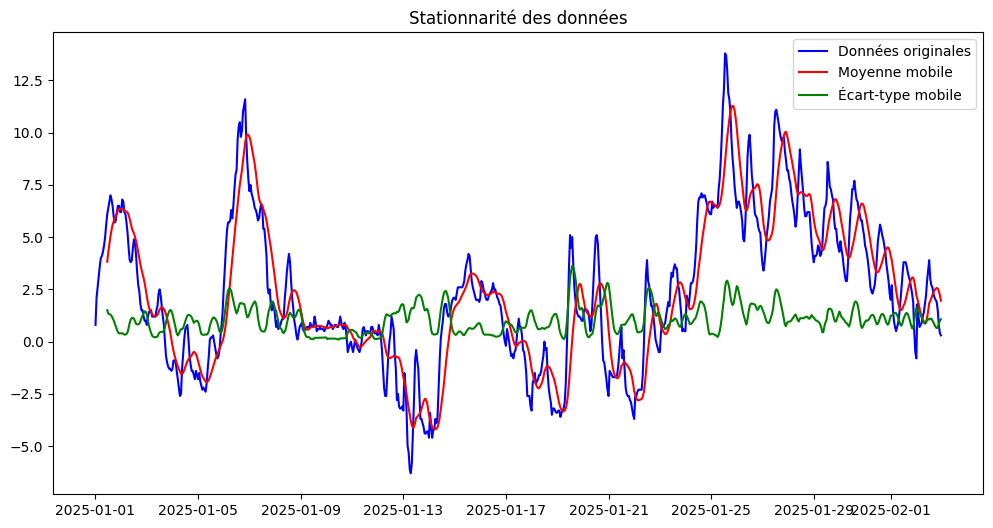

Statistique ADF : -2.506272107825606
p-value : 0.1139557021576712
La série n'est pas stationnaire (p-value >= 0.05).


In [40]:
from utils.adfuller import execute as adf_execute

# Calculer la moyenne mobile et l'écart-type mobile
rolling_mean = df['temperature'].rolling(window=12).mean()
rolling_std = df['temperature'].rolling(window=12).std()

# Tracer les données
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['temperature'], label='Données originales', color='blue')
plt.plot(rolling_mean, label='Moyenne mobile', color='red')
plt.plot(rolling_std, label='Écart-type mobile', color='green')
plt.legend(loc='best')
plt.title('Stationnarité des données')
plt.show()


adf_execute(df['temperature'])

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Essaie d'abord cette importation
try:
    from skforecast.ForecasterSarimax import ForecasterSarimax
    from skforecast.model_selection_sarimax import grid_search_sarimax
    print("Importation réussie avec le chemin ForecasterSarimax")
except ImportError:
    try:
        # Si ça ne marche pas, essaie celle-ci
        from skforecast.recursive._forecaster_sarimax import ForecasterSarimax
        from skforecast.model_selection import grid_search_sarimax
        print("Importation réussie avec le chemin recursive")
    except ImportError:
        print("Impossible d'importer, vérifie l'installation de skforecast")


Importation réussie avec le chemin recursive


In [42]:
from sklearn.model_selection import train_test_split

# Fractionner les données en ensembles d'entraînement et de test
train, test = train_test_split(df['temperature'], test_size=0.2, shuffle=False)

# Vérifier les dimensions des ensembles
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (633,)
Test shape: (159,)


In [ ]:
from skforecast import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Fractionnement des données
train, test = train_test_split(df['temperature'], test_size=0.2, shuffle=False)

# Paramètres de recherche
parametres = {
    'order': [(1,1,1), (2,1,2), (1,1,2)],
    'seasonal_order': [(0,1,1,24), (1,1,1,24)],
    'trend': [None, 'c', 'n']
}

# Création du forecaster avec le bon regressor
forecaster = ForecasterSarimax(
    regressor=Sarimax(order=(1,1,1), seasonal_order=(0,1,1,24))
)

# Recherche par grille
resultats = grid_search_sarimax(
    forecaster=forecaster,
    y=train,
    param_grid=parametres,
    steps=24,
    metric='rmse',
    verbose=True
)



ModuleNotFoundError: No module named 'skforecast.ForecasterSarimax'

c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\NeoSk\anaconda3\envs\learn-times-serie\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  633
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood                -317.340
Date:                            Fri, 11 Apr 2025   AIC                            642.680
Time:                                    16:25:43   BIC                            660.146
Sample:                                01-01-2025   HQIC                           649.489
                                     - 01-27-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5608      0.066      8.486      0.000       0.431       0.690
ma.L1         -0.1762      0.078   

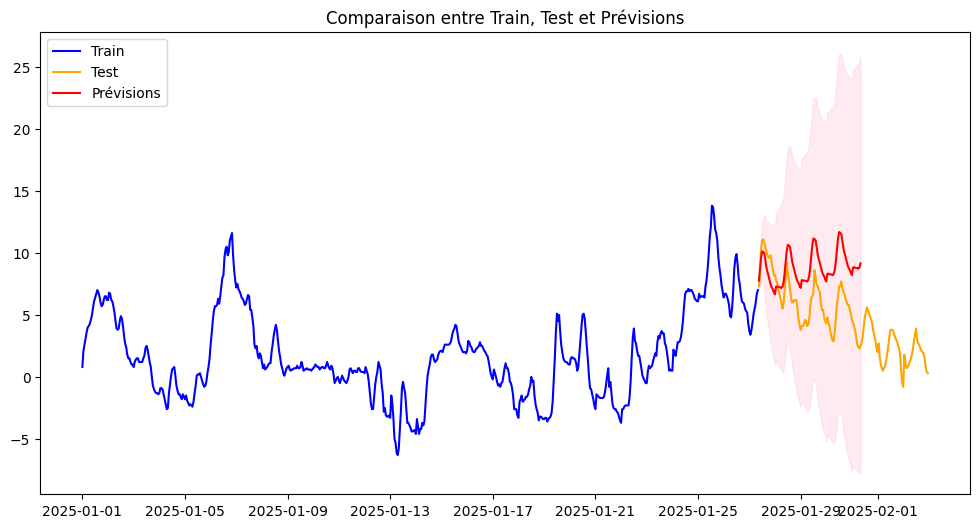

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ensure the required module is installed

# Ordre non-saisonnier (p,d,q) et saisonnier (P,D,Q,s)
# s=24 pour des données horaires avec cycle quotidien
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(0, 1, 1, 24),  # Suppression du terme AR saisonnier
                enforce_stationarity=False)

results = model.fit()
print(results.summary())

# Prédictions
pred = results.get_forecast(steps=96)  # Prédire 48h
pred_ci = pred.conf_int()

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, 
         color='red', label='Prévisions')
plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.legend()
plt.title('Comparaison entre Train, Test et Prévisions')
plt.show()
